In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

    # load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [3]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/기계학습 10주차/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1874727740.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [5]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]


In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
inputs = Input(shape=(n_timesteps,n_features))##128,9
x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(inputs) ##none,126,128
#maxpool1
x = MaxPooling1D(pool_size=5, strides=2)(x)

##Level_2
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
#maxpool2
x = MaxPooling1D(pool_size=5, strides=2)(x)

##Level_3
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)

#maxpool2
x = MaxPooling1D(pool_size=5, strides=2)(x)


#flatten
flat_cnn=Flatten()(x)


##dense layer
x = Dense(512, activation='relu')(flat_cnn)
output = Dense(n_outputs, activation='softmax')(x)

##MODEL
cnn_model = Model(inputs, output)

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 62, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 29, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 13, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,982 (980.40 KB)

 Trainable params: 250,982 (980.40 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model_history=cnn_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6842 - loss: 0.7539 - val_accuracy: 0.9406 - val_loss: 0.1381
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.1331 - val_accuracy: 0.9576 - val_loss: 0.1085
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9504 - loss: 0.1221 - val_accuracy: 0.9457 - val_loss: 0.1123
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9538 - loss: 0.1088 - val_accuracy: 0.9508 - val_loss: 0.0996
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9516 - loss: 0.1143 - val_accuracy: 0.9610 - val_loss: 0.1012
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9493 - loss: 0.1269 - val_accuracy: 0.9508 - val_loss: 0.1000
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9616 - loss: 0.0946 - val_accuracy: 0.9559 - val_loss: 0.0949
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9656 - loss: 0.0821 - val_accuracy: 0

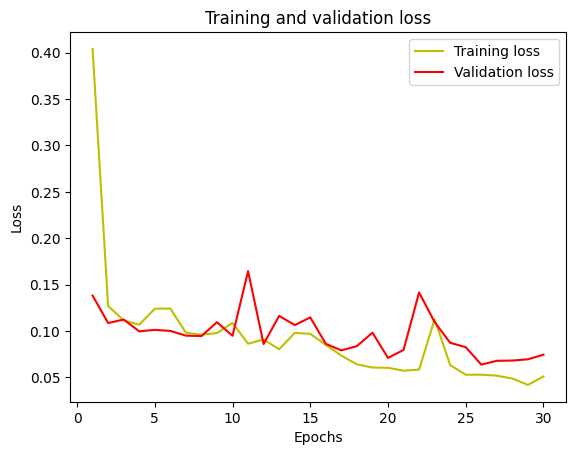

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

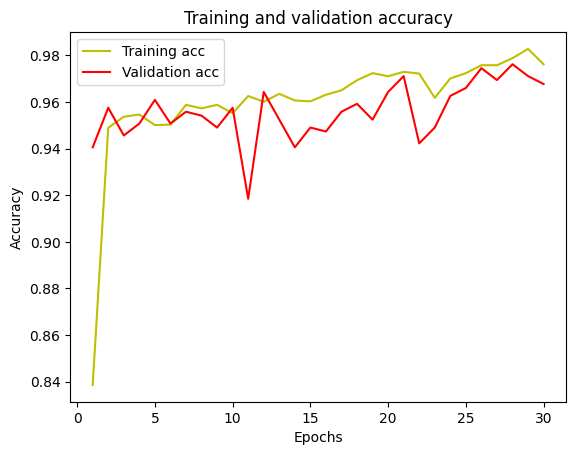

In [12]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[461  23   8   4   0   0]
 [  0 459   1  11   0   0]
 [  0   2 414   2   2   0]
 [  0   1   0 434  56   0]
 [  0   0   0  46 486   0]
 [  0  12   0   0  15 510]]
0.9379029521547336
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       496
           1       0.92      0.97      0.95       471
           2       0.98      0.99      0.98       420
           3       0.87      0.88      0.88       491
           4       0.87      0.91      0.89       532
           5       1.00      0.95      0.97       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



<Axes: >

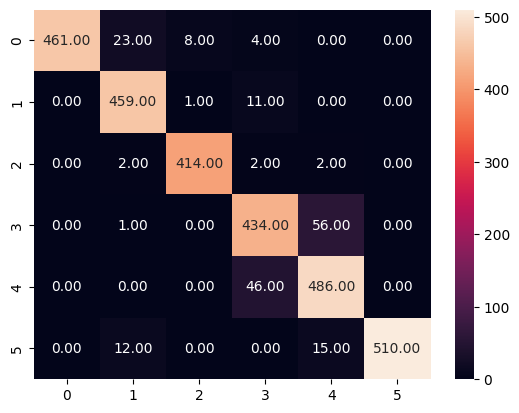

In [13]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=cnn_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')